<a href="https://colab.research.google.com/github/emaudealtema/Deep_learning_repository/blob/master/Copy_of_Land_Cover_Image_(Bad_Pred)_Classification_(TTT_VVGNet_UC_Merced_Pycharm_Methode).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://github.com/shakasom/multilabel-landcover-deeplearning/blob/master/Multi_label_Land_Cover_Classification.ipynb

In [ ]:
# Return a context manager that suppresses any of the specified exceptions if they 
# occur in the body of a with statement
from contextlib import suppress 
# for vizualisation
import matplotlib
import matplotlib.pyplot as plt

import numpy as np # for array computing

import os # for interacting with the operating system.
import warnings # alert when about some condition in the program
import shutil # for operations on individual files
from imutils import paths
from skimage.io import imread, imsave # image manupulation

'''
Keras Applications are deep learning models that 
are made available alongside pre-trained weights. 
These models can be used for prediction, 
feature extraction, and fine-tuning.
'''
from keras import applications 
from keras.applications import VGG16
from keras import optimizers #for compiling the keras model 
from keras.models import Sequential # to create the models layer-by-layer 

from keras import models
from keras import layers
from keras import optimizers

# layers
import glob
from keras.layers import Conv2D, MaxPool2D, Activation
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.utils import to_categorical #to convert array of labeled data
'''
ImageDataGenerator allow us to configure random 
transformations and normalization operations 
to be done on the image data during training
'''
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [ ]:
!unzip -q "/content/drive/My Drive/Dataset/Image Classification/Classification Image Satellite/small dataset/UC_MERCED.zip" -d "/content/data"

In [ ]:
base_dir = "/content/data/UC_MERCED"
train_dir = os.path.join(base_dir, 'images')

In [ ]:
class_names = os.listdir(train_dir)  
print ("There are ", len(class_names), "classes:\n")
class_names

There are  5 classes:



['airplane', 'beach', 'cloud', 'forest', 'intersection']

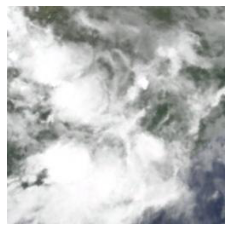

In [ ]:
plt.imshow(imread('/content/data/UC_MERCED/images/cloud/cloud_001.jpg'))
plt.axis('off')
plt.show()

In [ ]:
# Set random seed for reproducibility
np.random.seed(5)

In [ ]:
source_dir = os.path.join('data', 'UC_MERCED', 'images')
# Collect class names from directory names in './data/UCMerced_LandUse/Images/'
class_names = os.listdir(source_dir)    

# Create path to image "flow" base directory
flow_base = os.path.join('data', 'flow')

In [ ]:
# Create pathnames to train/validate/test subdirectories
target_dirs = {target: os.path.join(flow_base, target) for target in ['train', 'validate', 'test']}

In [ ]:
if not os.path.isdir(flow_base):

    # Make new directories
    os.mkdir(flow_base)
    
    for target in ['train', 'validate', 'test']:
        target_dir = os.path.join(flow_base, target)
        os.mkdir(target_dir)
        for class_name in class_names:
            class_subdir = os.path.join(target_dir, class_name)
            os.mkdir(class_subdir)

    # suppress low-contrast warning from skimage.io.imsave
    warnings.simplefilter('ignore', UserWarning)
    
    # Copy images from ./data/UCMerced_LandUse/Images to ./data/flow/<train, validate, test>    
    for root, _, filenames in os.walk(source_dir):
        if filenames:
            class_name = os.path.basename(root)

            # Randomly shuffle filenames
            filenames = np.random.permutation(filenames)
            for target, count in [('train', 80), ('validate', 10), ('test', 10)]:
                target_dir = os.path.join(flow_base, target, class_name)
                for filename in filenames[:count]:
                    filepath = os.path.join(root, filename)
                    image = imread(filepath)
                    basename, _ = os.path.splitext(filename)
                    # Convert TIF to PNG to work with Keras ImageDataGenerator.flow_from_directory
                    target_filename = os.path.join(target_dir, basename + '.png')
                    imsave(target_filename, image)
            
                filenames = filenames[count:]
    
    # Show future warnings during development
    warnings.resetwarnings()

In [ ]:
train_dir=os.path.join('data/flow','train')
validation_dir=os.path.join('data/flow','validate')
test_dir=os.path.join('data/flow','test')

In [ ]:
# initialize the training data augmentation object
trainAug = ImageDataGenerator(
		# rescale=1.0/255.0,
	rotation_range=10,
	# zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")
# initialize the validation/testing data augmentation object (which
# we'll be adding mean subtraction to)
valAug = ImageDataGenerator()
# define the ImageNet mean subtraction (in RGB order) and set the
# the mean subtraction value for each of the data augmentation
# objects
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [ ]:
# initialize the training generator
trainGen = trainAug.flow_from_directory(
	train_dir,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=True,
	batch_size=64)
# initialize the validation generator
valGen = valAug.flow_from_directory(
	validation_dir,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=64)
# initialize the testing generator
testGen = valAug.flow_from_directory(
	test_dir,
	class_mode="categorical",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=64)

Found 400 images belonging to 5 classes.
Found 50 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


In [ ]:
# load the VGG16 network, ensuring the head FC layer sets are left off
from keras.applications import VGG16
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(class_names), activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
# compile our model (this needs to be done after our setting our
# layers to being non-trainable
print("[INFO] compiling model...")
opt = optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
# train the head of the network for a few epochs (all other layers
# are frozen) -- this will allow the new FC layers to start to become
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
model_history = model.fit(
	x=trainGen,
	steps_per_epoch=len(list(paths.list_images(train_dir))) // 64,
	validation_data=valGen,
	validation_steps=len(list(paths.list_images(validation_dir))) // 64,
	epochs=50)

[INFO] training head...
Epoch 1/50
6/6 [==============================] - 5s 901ms/step - loss: 14.0122 - accuracy: 0.2679
Epoch 2/50
6/6 [==============================] - 5s 759ms/step - loss: 6.5011 - accuracy: 0.5565
Epoch 3/50
6/6 [==============================] - 5s 800ms/step - loss: 2.5990 - accuracy: 0.7560
Epoch 4/50
6/6 [==============================] - 5s 785ms/step - loss: 2.4707 - accuracy: 0.8155
Epoch 5/50
6/6 [==============================] - 5s 787ms/step - loss: 1.8175 - accuracy: 0.8363
Epoch 6/50
6/6 [==============================] - 5s 910ms/step - loss: 1.7723 - accuracy: 0.8724
Epoch 7/50
6/6 [==============================] - 5s 808ms/step - loss: 1.0714 - accuracy: 0.8690
Epoch 8/50
6/6 [==============================] - 6s 946ms/step - loss: 0.9401 - accuracy: 0.8869
Epoch 9/50
6/6 [==============================] - 5s 912ms/step - loss: 1.1863 - accuracy: 0.8828
Epoch 10/50
6/6 [==============================] - 5s 787ms/step - loss: 0.8070 - accuracy: 0

### Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
# Print classification results
# Flatten Y into a vector
# y_test = np.nonzero(Y['test'])[1]
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Model predication accuracy: {accuracy:.3f}')

In [ ]:
def plot_training(H, N):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
	plt.plot(np.arange(0, N), H.history["val"], label="val_loss")
	plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
	plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.show()

In [ ]:
# reset the testing generator and evaluate the network after
# fine-tuning just the network head
print("[INFO] evaluating after fine-tuning network head...")
testGen.reset()
predIdxs = model.predict(x=testGen, steps=(len(list(paths.list_images(test_dir))) // 64) + 1)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxs, target_names=testGen.class_indices.keys()))
plot_training(model_history, 50)

In [ ]:
def plot_loss(history):
  # Plot training loss vs. validation loss
  matplotlib.style.use('seaborn')
  epochs = len(model_history.history['loss'])
  max_loss = max(max(model_history.history['loss']), max(model_history.history['val_loss']))
  plt.axis([0, epochs+1, 0, round(max_loss * 2.0) / 2 + 0.5])
  x = np.arange(1, epochs+1)
  plt.plot(x, model_history.history['loss'])
  plt.plot(x, model_history.history['val_loss'])
  plt.title('Training loss vs. Validation loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='right')
  plt.show()

In [ ]:
# Plot of training accuracy vs. validation accuracy
def plot_accuracy(history):
  matplotlib.style.use('seaborn')
  epochs = len(model_history.history['accuracy'])
  plt.axis([0, epochs+1, 0, 1.2])
  x = np.arange(1, epochs+1)
  plt.plot(x, model_history.history['accuracy'])
  plt.plot(x, model_history.history['val_accuracy'])
  plt.title('Training accuracy vs. Validation accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='right')
  plt.show()

In [ ]:
# plot_loss(model_history)

In [ ]:
# plot_accuracy(model_history)

In [ ]:
model.save('TTTVVGNet-UC_MERCED_Pycharm Methode_model3.h5')

### Prediction 2

In [ ]:
# import the necessary packages
from tensorflow.keras.models import load_model
# from pyimagesearch import config
from google.colab.patches import cv2_imshow
import numpy as np
import argparse
import imutils
import cv2

In [ ]:
def prediction_image(image, class_names, model):
  # load the input image and then clone it so we can draw on it later
  output = image.copy()
  output = imutils.resize(output, width=400)
  # our model was trained on RGB ordered images but OpenCV represents
  # images in BGR order, so swap the channels, and then resize to
  # 224x224 (the input dimensions for VGG16)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (224, 224))
  # convert the image to a floating point data type and perform mean
  # subtraction
  image = image.astype("float32")
  mean = np.array([123.68, 116.779, 103.939][::1], dtype="float32")
  image -= mean
  # pass the image through the network to obtain our predictions
  preds = model.predict(np.expand_dims(image, axis=0))[0]
  i = np.argmax(preds)
  label = class_names[i]
  # draw the prediction on the output image
  text = "{}: {:.2f}%".format(label, preds[i] * 100)
  cv2.putText(output, text, (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
	(0, 255, 0), 2)
  # show the output image
  cv2_imshow(output)

In [ ]:
# load the trained model from disk
print("[INFO] loading model...")
model = load_model('/content/TTTVVGNet-UC_MERCED_Pycharm Methode_model3.h5')

[INFO] loading model...


In [ ]:
# load the input image and then clone it so we can draw on it later
image = cv2.imread('/content/data/UC_MERCED/airplane/airplane_001.jpg')

# New Section

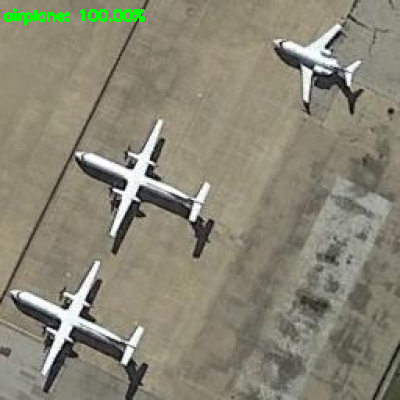

In [ ]:
prediction_image(image, class_names,model)

In [ ]:
image2 = cv2.imread('/content/data/flow/test/airplane/airplane_017.png')

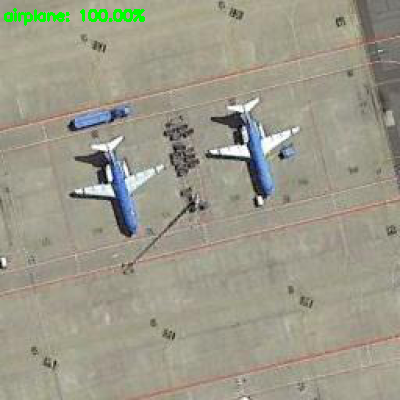

In [ ]:
prediction_image(image2, class_names,model)

In [ ]:
image3 = cv2.imread('/content/data/flow/test/beach/beach_017.png')

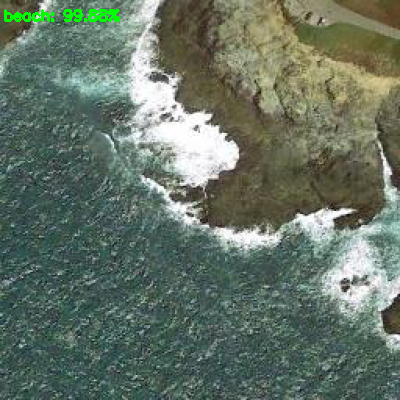

In [ ]:
prediction_image(image3, class_names,model)

In [ ]:
image4 = cv2.imread('/content/data/UC_MERCED/cloud/cloud_001.jpg')

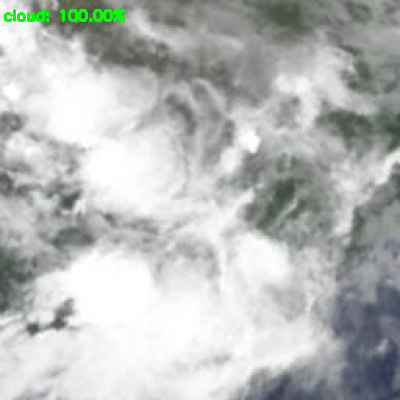

In [ ]:
prediction_image(image4, class_names,model)

In [ ]:
image5 = cv2.imread('/content/data/flow/test/beach/beach_145.png')

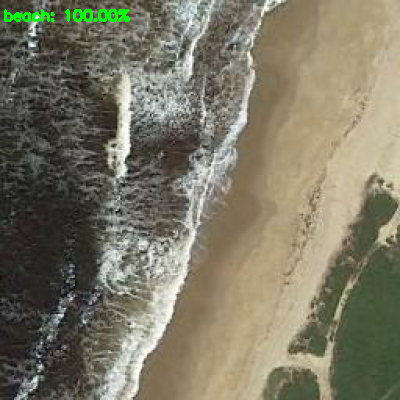

In [ ]:
prediction_image(image5, class_names, model)

In [ ]:
image7 = cv2.imread('/content/data/flow/test/intersection/intersection_018.png')

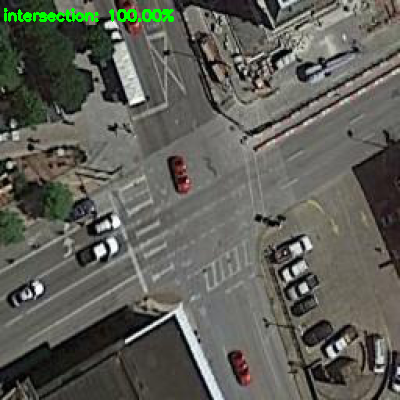

In [ ]:
prediction_image(image7, class_names, model)

In [ ]:
image8 = cv2.imread('/content/data/flow/test/forest/forest_163.png')

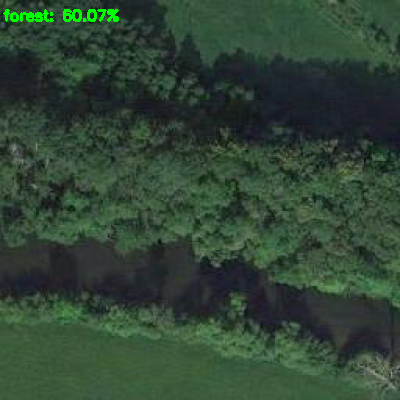

In [ ]:
prediction_image(image8, class_names, model)

In [ ]:
image9 = cv2.imread('/content/data/flow/test/intersection/intersection_364.png')

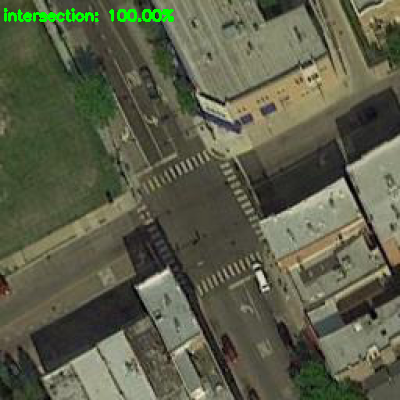

In [ ]:
prediction_image(image9, class_names, model)

In [ ]:
image10 = cv2.imread('/content/data/flow/test/forest/forest_240.png')

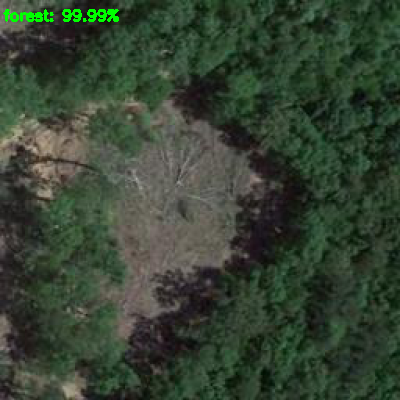

In [ ]:
prediction_image(image10, class_names, model)

In [ ]:
image11 = cv2.imread('/content/data/flow/test/cloud/cloud_223.png')

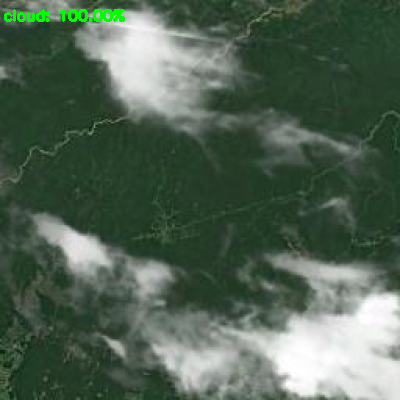

In [ ]:
prediction_image(image11, class_names, model)